# Steatosis Classification Model Fine-tuning

This notebook implements the fine-tuning process with comprehensive metric tracking.

In [126]:
import sys
sys.path.append('..')  # Add parent directory to Python path

In [127]:
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from pathlib import Path
import json
from datetime import datetime
from tqdm.notebook import tqdm
from collections import defaultdict
import pandas as pd
import seaborn as sns

from src.model import SteatosisModel, get_loss_fn
from src.data import create_dataloaders
from src.evaluation import MetricsCalculator

# Set random seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

## Configuration

In [128]:
# Paths
MODEL_PATH = '../Models/DenseNet121_processed.pt'
DATA_DIR = '../DataSet'
OUTPUT_DIR = '../training_output'
LOG_DIR = '../logs'

# Training parameters
RUN_NAME = 'DenseNet121_processed-'+ datetime.now().strftime("%Y%m%d-%H%M")
BATCH_SIZE = 16
BINARY = False
NUM_CLASSES = 2 if BINARY else 3

# Create directories
Path(OUTPUT_DIR).mkdir(exist_ok=True)
Path(LOG_DIR).mkdir(exist_ok=True)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [129]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda if torch.cuda.is_available() else 'Not available'}")
print(f"GPU device name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU'}")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
GPU device name: NVIDIA GeForce RTX 3060 Laptop GPU


## Data Loading

In [130]:
train_samples, val_samples = create_dataloaders(
    data_dir=DATA_DIR,
    batch_size=1,
    binary=BINARY
)

train_loader, val_loader = create_dataloaders(
    data_dir=DATA_DIR,
    batch_size=BATCH_SIZE,
    binary=BINARY
)

print(f"Training samples: {len(train_samples)}")
print(f"Validation samples: {len(val_samples)}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

tensor([0.5144, 1.3782, 3.0253])
tensor([0.7738, 1.2801, 1.0792])
tensor([0.5144, 1.3782, 3.0253])
tensor([0.7738, 1.2801, 1.0792])
Training samples: 4420
Validation samples: 722
Training batches: 277
Validation batches: 46


In [131]:
print(next(iter(train_loader)))

[tensor([[[[-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0665, -2.0665],
          [-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0665, -2.0665],
          [-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0665, -2.0665],
          ...,
          [-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0665, -2.0665],
          [-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0665, -2.0665],
          [-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0665, -2.0665]],

         [[-1.9832, -1.9832, -1.9832,  ..., -1.9832, -1.9832, -1.9832],
          [-1.9832, -1.9832, -1.9832,  ..., -1.9832, -1.9832, -1.9832],
          [-1.9832, -1.9832, -1.9832,  ..., -1.9832, -1.9832, -1.9832],
          ...,
          [-1.9832, -1.9832, -1.9832,  ..., -1.9832, -1.9832, -1.9832],
          [-1.9832, -1.9832, -1.9832,  ..., -1.9832, -1.9832, -1.9832],
          [-1.9832, -1.9832, -1.9832,  ..., -1.9832, -1.9832, -1.9832]],

         [[-1.7522, -1.7522, -1.7522,  ..., -1.7522, -1.7522, -1.7522],
          [-1.7522, -1.7522, 

## Model Setup

In [132]:
# Initialize model and training components
model = SteatosisModel(
    pretrained_path=MODEL_PATH,
    num_classes=NUM_CLASSES,
    freeze_layers=True
).to(device)

optimizer = model.create_optimizer(
    model.get_trainable_params(),
    optimizer_type='adam',
    lr=1e-3
)
scheduler = model.create_scheduler(optimizer, scheduler_type='plateau')
loss_fn = get_loss_fn(NUM_CLASSES)
metrics_calculator = MetricsCalculator(device=device)

Successfully loaded pretrained weights


## Training Functions

In [133]:
def compute_metrics(outputs, targets, metrics_calculator):
    """Compute metrics for a batch or epoch."""
    if BINARY == 1:
        outputs = torch.sigmoid(outputs).squeeze(1)
        metrics = metrics_calculator.compute_basic_metrics(targets, outputs)
        metrics.update(
            metrics_calculator.compute_roc_auc(targets, outputs)
        )
    # For multi-class classification
    else:
        outputs = torch.softmax(outputs, dim=1)
        metrics = metrics_calculator.compute_multiclass_metrics(targets, outputs)
        metrics.update(
            metrics_calculator.compute_roc_auc(targets, outputs, multi_class=True)
        )
    return metrics

# Reset BatchNorm statistics before validation
def reset_bn_stats(model):
    for m in model.modules():
        if isinstance(m, torch.nn.BatchNorm2d):
            m.reset_running_stats()
            m.momentum = 0.1  # Default momentum

def train_epoch(model, train_loader, optimizer, loss_fn, metrics_calculator, device):
    """Train for one epoch with detailed metric tracking."""
    model.train()
    total_loss = 0.0
    all_outputs = []
    all_targets = []
    
    with tqdm(train_loader, desc='Training') as pbar:
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            # print(".......................")
            # print("before modification")
            # print(output.shape)
            # print(output)
            # print(target.shape)
            # print(target)
            # print(".......................")

            
            if output.shape[1] == 1:  # Binary classification
                output = output.squeeze(1)
                target = target.float()
            
            # print(".......................")
            # print("after modification")
            # print(output.shape)
            # print(output)
            # print(target.shape)
            # print(target)
            # print(".......................")
            loss = loss_fn(output, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            all_outputs.append(output.detach())
            all_targets.append(target)
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f"{loss.item():.4f}",
            })
    
    # Compute epoch metrics
    outputs = torch.cat(all_outputs)
    targets = torch.cat(all_targets)
    epoch_metrics = compute_metrics(outputs, targets, metrics_calculator)
    epoch_metrics['loss'] = total_loss / len(train_loader)
    
    return epoch_metrics

def validate(model, val_loader, loss_fn, metrics_calculator, device):
    """Validate model and compute metrics."""
    model.eval()
    total_loss = 0.0
    all_outputs = []
    all_targets = []
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(val_loader, desc='Validation')):
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # print(".......................")
            # print("before modification")
            # print(output.shape)
            # print(output)
            # print(target.shape)
            # print(target)
            # print(".......................")
            if output.shape[1] == 1:  # Binary classification
                output = output.squeeze(1)
                target = target.float()
            
            loss = loss_fn(output, target)
            total_loss += loss.item()

            # Store for metrics calculation
            all_outputs.append(output)
            all_targets.append(target)
        
    
    # Compute epoch metrics
    outputs = torch.cat(all_outputs)
    targets = torch.cat(all_targets)
    # print("outputs")
    # print(outputs.shape)
    # print(outputs)
    # print("targets")
    # print(targets.shape)
    # print(targets)
    epoch_metrics = compute_metrics(outputs, targets, metrics_calculator)
    print("epoch_metrics")
    epoch_metrics['loss'] = total_loss / len(val_loader)
    
    return epoch_metrics

def log_metrics(metrics, phase, epoch, step=None):
    """Log metrics to JSON file."""
    log_entry = {
        'timestamp': datetime.now().isoformat(),
        'phase': phase,
        'epoch': epoch,
        'metrics': metrics
    }
    if step is not None:
        log_entry['step'] = step
    
    log_file = Path(LOG_DIR) / f'training_metrics-{RUN_NAME}.json'
    
    # Load existing logs if any
    if log_file.exists():
        with open(log_file, 'r') as f:
            logs = json.load(f)
    else:
        logs = []
    
    # Append new log entry
    logs.append(log_entry)
    
    # Save updated logs
    with open(log_file, 'w') as f:
        json.dump(logs, f, indent=2)

## Training Loop

In [136]:
# Training phases configuration
phases = [
    {'name': 'Classifier Only', 'epochs': 10, 'blocks': None, 'lr': 1e-3},
    {'name': 'Partial Unfreeze', 'epochs': 15, 'blocks': 2, 'lr': 1e-4},
    {'name': 'Full Fine-tuning', 'epochs': 20, 'blocks': None, 'lr': 1e-5}
]

# Training history
history = defaultdict(list)

# Best model tracking
best_metric = 0.0
patience_counter = 0
early_stopping_patience = 5

try:
    # Training loop
    for phase_idx, phase in enumerate(phases):
        print(f"\nStarting {phase['name']} (Phase {phase_idx + 1})")
        print(f"Learning rate: {phase['lr']}")
        
        # Update model for this phase
        model.unfreeze_layers(phase['blocks'])
        for param_group in optimizer.param_groups:
            param_group['lr'] = phase['lr']
        
        for epoch in range(phase['epochs']):
            print(f"\nEpoch {epoch + 1}/{phase['epochs']}")
            
            # Train
            train_metrics = train_epoch(
                model, train_loader, optimizer, loss_fn, metrics_calculator, device
            )
            
            # Log training metrics
            log_metrics(train_metrics, 'train', epoch)
            
            # Validate
            val_metrics = validate(
                model, val_loader, loss_fn, metrics_calculator, device
            )
            
            # Log validation metrics
            log_metrics(val_metrics, 'val', epoch)
            
            # Update learning rate scheduler
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                if BINARY:
                    scheduler.step(val_metrics['roc_auc'])
                else:
                    scheduler.step(val_metrics['macro']['macro_f1_score'])
            else:
                scheduler.step()
            
            # Update history
            for k, v in train_metrics.items():
                history[f'train_{k}'].append(v)
            for k, v in val_metrics.items():
                history[f'val_{k}'].append(v)
            
            # Print metrics
            if BINARY:
                print(
                    f"Train Loss: {train_metrics['loss']:.4f}, "
                    f"F1: {train_metrics['f1_score']:.4f}, "
                    f"AUC: {train_metrics['roc_auc']:.4f}\n"
                    f"Val Loss: {val_metrics['loss']:.4f}, "
                    f"F1: {val_metrics['f1_score']:.4f}, "
                    f"AUC: {val_metrics['roc_auc']:.4f}"
                )
            else: 
                print(
                    f"Train Loss: {train_metrics['loss']:.4f}, "
                    f"Macro F1: {train_metrics['macro']['macro_f1_score']:.4f}\n"
                    f"Macro Roc Auc: {train_metrics['macro_roc_auc']:.4f}\n"
                    f"Val Loss: {val_metrics['loss']:.4f}, "
                    f"Macro F1: {val_metrics['macro']['macro_f1_score']:.4f}, "
                    f"Macro Roc Auc: {val_metrics['macro_roc_auc']:.4f}"
                )
            
            # Save best model
            if BINARY and val_metrics['f1_score'] > best_metric:
                best_metric = val_metrics['f1_score']
            elif not BINARY and val_metrics['macro']['macro_f1_score'] > best_metric:
                best_metric = val_metrics['macro']['macro_f1_score']
                # model.save(f"{OUTPUT_DIR}/best_model.pt")
                torch.save(model.state_dict(), f"{OUTPUT_DIR}/best_model_state_dict.pt")
                patience_counter = 0
                print(f"New best model saved! F1: {best_metric:.4f}")
            else:
                patience_counter += 1
            
            # Early stopping
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping triggered after {patience_counter} epochs without improvement")
                state_dict = torch.load(f"{OUTPUT_DIR}/best_model_state_dict.pt")
                model.load_state_dict(state_dict)
                # model.load(f"{OUTPUT_DIR}/best_model.pt")  # Load best model
                patience_counter = 0
                break
        
        # Save phase checkpoint
        model.save(f"{OUTPUT_DIR}/phase_{phase_idx + 1}_model.pt")
        
    # Save final history
    with open(f"{OUTPUT_DIR}/training_history.json", 'w') as f:
        json.dump(history, f, indent=2)
        
except Exception as e:
    print(f"Error during training: {str(e)}")
    raise


Starting Classifier Only (Phase 1)
Learning rate: 0.001

Epoch 1/10


Training:   0%|          | 0/277 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

epoch_metrics
Train Loss: 1.0433, Macro F1: 0.0825
Macro Roc Auc: 0.6477
Val Loss: 40267.7198, Macro F1: 0.1571, Macro Roc Auc: 0.6603
New best model saved! F1: 0.1571

Epoch 2/10


Training:   0%|          | 0/277 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

epoch_metrics
Train Loss: 1.0422, Macro F1: 0.1063
Macro Roc Auc: 0.6409
Val Loss: 56024.0010, Macro F1: 0.1365, Macro Roc Auc: 0.6667

Epoch 3/10


Training:   0%|          | 0/277 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

epoch_metrics
Train Loss: 1.0399, Macro F1: 0.1137
Macro Roc Auc: 0.6491
Val Loss: 27563.9905, Macro F1: 0.0866, Macro Roc Auc: 0.6559

Epoch 4/10


Training:   0%|          | 0/277 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

epoch_metrics
Train Loss: 1.0339, Macro F1: 0.1317
Macro Roc Auc: 0.6551
Val Loss: 21580.4189, Macro F1: 0.1316, Macro Roc Auc: 0.6416

Epoch 5/10


Training:   0%|          | 0/277 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

epoch_metrics
Train Loss: 1.0372, Macro F1: 0.1375
Macro Roc Auc: 0.6482
Val Loss: 45372.9694, Macro F1: 0.1618, Macro Roc Auc: 0.6735
New best model saved! F1: 0.1618

Epoch 6/10


Training:   0%|          | 0/277 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

epoch_metrics
Train Loss: 1.0332, Macro F1: 0.1438
Macro Roc Auc: 0.6544
Val Loss: 50633.5942, Macro F1: 0.1144, Macro Roc Auc: 0.6693

Epoch 7/10


Training:   0%|          | 0/277 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

epoch_metrics
Train Loss: 1.0336, Macro F1: 0.1387
Macro Roc Auc: 0.6528
Val Loss: 63667.1300, Macro F1: 0.1420, Macro Roc Auc: 0.6795

Epoch 8/10


Training:   0%|          | 0/277 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

epoch_metrics
Train Loss: 1.0241, Macro F1: 0.1530
Macro Roc Auc: 0.6632
Val Loss: 75594.1143, Macro F1: 0.2456, Macro Roc Auc: 0.6929
New best model saved! F1: 0.2456

Epoch 9/10


Training:   0%|          | 0/277 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

epoch_metrics
Train Loss: 1.0267, Macro F1: 0.1632
Macro Roc Auc: 0.6605
Val Loss: 28959.5295, Macro F1: 0.1019, Macro Roc Auc: 0.6615

Epoch 10/10


Training:   0%|          | 0/277 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

epoch_metrics
Train Loss: 1.0249, Macro F1: 0.1499
Macro Roc Auc: 0.6638
Val Loss: 83400.9875, Macro F1: 0.2345, Macro Roc Auc: 0.6890

Starting Partial Unfreeze (Phase 2)
Learning rate: 0.0001

Epoch 1/15


Training:   0%|          | 0/277 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

epoch_metrics
Train Loss: 1.0314, Macro F1: 0.1409
Macro Roc Auc: 0.6558
Val Loss: 41685.7570, Macro F1: 0.2099, Macro Roc Auc: 0.6605

Epoch 2/15


Training:   0%|          | 0/277 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

epoch_metrics
Train Loss: 1.0262, Macro F1: 0.1444
Macro Roc Auc: 0.6625
Val Loss: 49790.4843, Macro F1: 0.2196, Macro Roc Auc: 0.6726

Epoch 3/15


Training:   0%|          | 0/277 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

epoch_metrics
Train Loss: 1.0237, Macro F1: 0.1651
Macro Roc Auc: 0.6639
Val Loss: 35981.6646, Macro F1: 0.2338, Macro Roc Auc: 0.6536
Early stopping triggered after 5 epochs without improvement

Starting Full Fine-tuning (Phase 3)
Learning rate: 1e-05

Epoch 1/20


Training:   0%|          | 0/277 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

epoch_metrics
Train Loss: 1.0347, Macro F1: 0.1573
Macro Roc Auc: 0.6523
Val Loss: 102683.4391, Macro F1: 0.2111, Macro Roc Auc: 0.6783

Epoch 2/20


Training:   0%|          | 0/277 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

epoch_metrics
Train Loss: 1.0294, Macro F1: 0.1492
Macro Roc Auc: 0.6574
Val Loss: 94208.3334, Macro F1: 0.1676, Macro Roc Auc: 0.6627

Epoch 3/20


Training:   0%|          | 0/277 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

epoch_metrics
Train Loss: 1.0244, Macro F1: 0.1471
Macro Roc Auc: 0.6688
Val Loss: 21331.0110, Macro F1: 0.2069, Macro Roc Auc: 0.6697

Epoch 4/20


Training:   0%|          | 0/277 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

epoch_metrics
Train Loss: 1.0278, Macro F1: 0.1463
Macro Roc Auc: 0.6650
Val Loss: 32303.9696, Macro F1: 0.1373, Macro Roc Auc: 0.6522

Epoch 5/20


Training:   0%|          | 0/277 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

epoch_metrics
Train Loss: 1.0262, Macro F1: 0.1545
Macro Roc Auc: 0.6620
Val Loss: 27224.0445, Macro F1: 0.2101, Macro Roc Auc: 0.6781
Early stopping triggered after 5 epochs without improvement


## Training Visualization

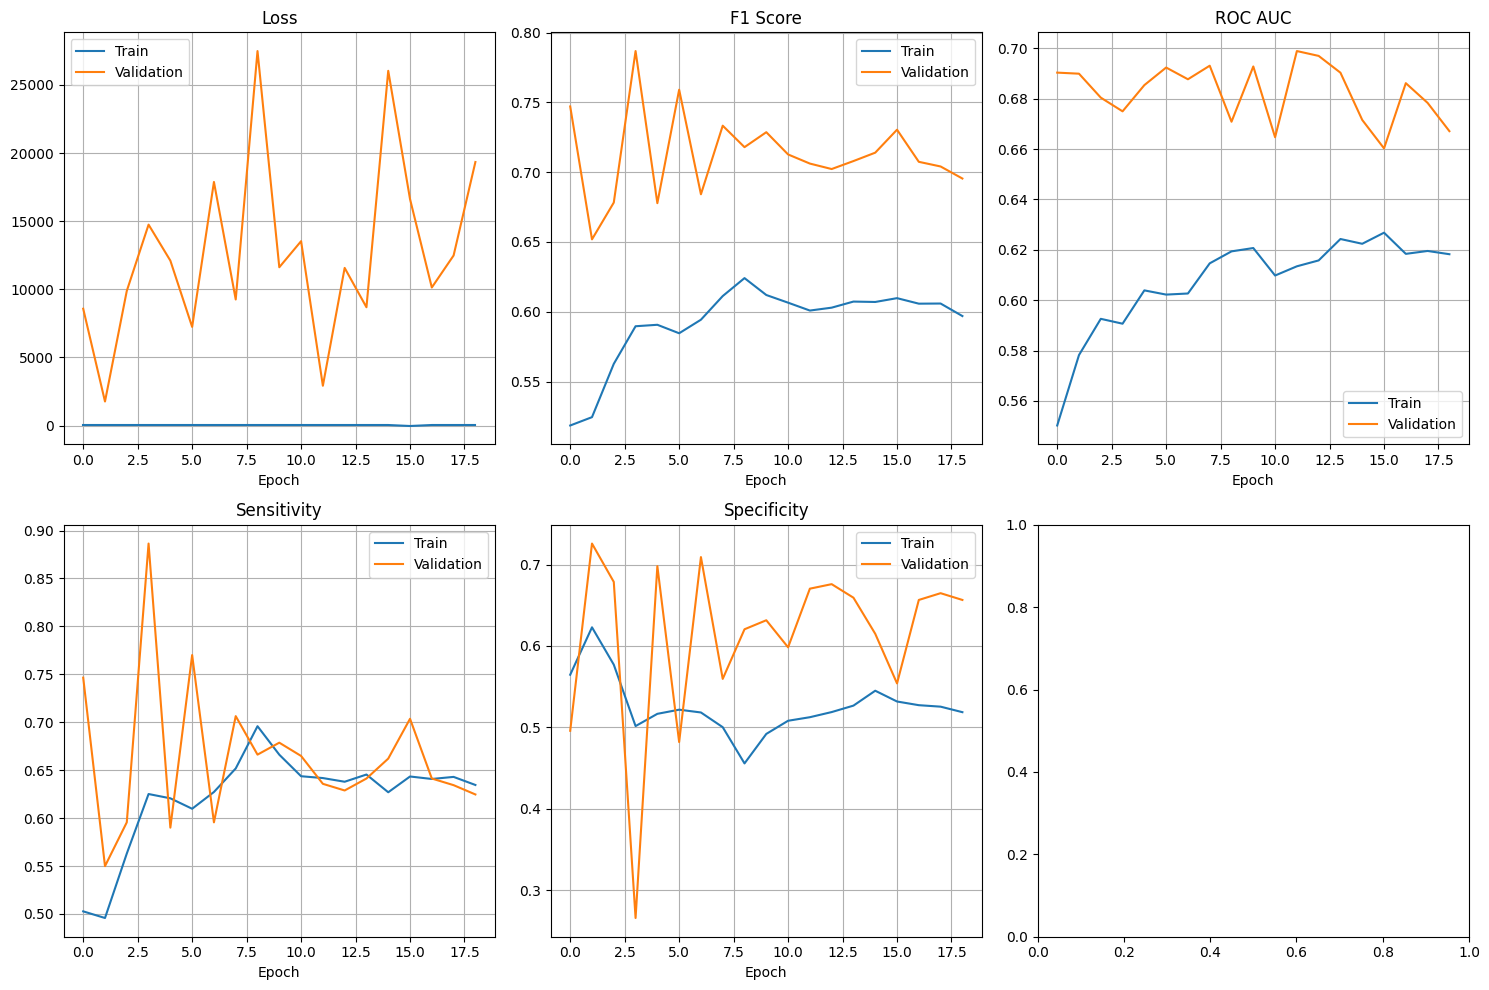


Final training metrics:


KeyError: 'phase'

In [ ]:
def plot_metrics(history):
    """Plot training and validation metrics."""
    metrics = [
        ('loss', 'Loss'),
        ('f1_score', 'F1 Score'),
        ('roc_auc', 'ROC AUC'),
        ('sensitivity', 'Sensitivity'),
        ('specificity', 'Specificity')
    ]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, (metric, title) in enumerate(metrics):
        if idx < len(axes):
            train_key = f'train_{metric}'
            val_key = f'val_{metric}'
            
            if train_key in history and val_key in history:
                axes[idx].plot(history[train_key], label='Train')
                axes[idx].plot(history[val_key], label='Validation')
                axes[idx].set_title(title)
                axes[idx].set_xlabel('Epoch')
                axes[idx].grid(True)
                axes[idx].legend()
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/training_metrics.png")
    plt.show()

# Plot training history
plot_metrics(history)

# Load and display detailed metrics
with open(f"{LOG_DIR}/training_metrics.json", 'r') as f:
    logs = json.load(f)

# Convert to DataFrame for analysis
df = pd.json_normalize(logs)
print("\nFinal training metrics:")
print(df[df['phase'] == 'train'].tail())
print("\nFinal validation metrics:")
print(df[df['phase'] == 'val'].tail())